In [1]:
import glob
import numpy as np
import xarray as xr
from munkres import Munkres
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [2]:
real = 'synthetic'
h_idx = 9
model_loc = "/glade/work/schreck/repos/HOLO/clean/holodec-ml/results/optimized_noiseless/"
model_save = "/glade/scratch/ggantos/holodec/models/optimized_noiseless/"


In [3]:
z_file_indices = sorted([int(x.replace(".npz", "").split("_")[-1]) for x in glob.glob(f"{model_loc}/{real}/propagated/true_{h_idx}_*")])
print(f"z_file_indices range from {min(z_file_indices)} to {max(z_file_indices)}.")


z_file_indices range from 14072 to 157928.


In [4]:
ds = xr.open_dataset("/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc")

# define dataset attributes
dx = ds.attrs['dx']      # horizontal resolution
dy = ds.attrs['dy']      # vertical resolution
Nx = int(ds.attrs['Nx']) # number of horizontal pixels
Ny = int(ds.attrs['Ny']) # number of vertical pixels
zMin = ds.attrs['zMin']  # minimum z in sample volume
zMax = ds.attrs['zMax']
dz = (zMax - zMin) / 1000
ds["d"].attrs


{'longname': 'Particle Diameter', 'units': 'microns'}

In [5]:
# define true particle coordinates
particle_idx = np.where(ds['hid'].values==h_idx+1)

x_part = ds['x'].values[particle_idx]
y_part = ds['y'].values[particle_idx]
z_part = ds['z'].values[particle_idx]
d_part = ds['d'].values[particle_idx]


In [6]:
objects_true = np.load(f"{model_save}inference/{real}/objects_true_{h_idx}.npy", allow_pickle=True)
objects_true

array([[slice(1, 2, None), slice(208, 221, None),
        slice(3082, 3094, None)],
       [slice(2, 3, None), slice(2061, 2069, None),
        slice(1567, 1575, None)],
       [slice(6, 7, None), slice(546, 553, None), slice(443, 451, None)],
       ...,
       [slice(993, 994, None), slice(4740, 4747, None),
        slice(660, 667, None)],
       [slice(995, 996, None), slice(2611, 2616, None),
        slice(2462, 2468, None)],
       [slice(996, 997, None), slice(2701, 2709, None),
        slice(192, 201, None)]], dtype=object)

In [7]:
objects_pred = np.load(f"{model_save}inference/{real}/objects_pred_{h_idx}.npy", allow_pickle=True)
objects_pred

array([[slice(1, 2, None), slice(208, 221, None),
        slice(3082, 3094, None)],
       [slice(1, 3, None), slice(2061, 2069, None),
        slice(1567, 1575, None)],
       [slice(5, 7, None), slice(545, 554, None), slice(443, 451, None)],
       ...,
       [slice(991, 994, None), slice(4740, 4746, None),
        slice(660, 667, None)],
       [slice(993, 996, None), slice(2611, 2616, None),
        slice(2462, 2468, None)],
       [slice(994, 997, None), slice(2701, 2709, None),
        slice(193, 201, None)]], dtype=object)

In [8]:
# TODO fill np.zeroes instead of lists

z_true = []
x_true = []
y_true = []
d_true = []

for obj in objects_true:
    z_true.append(z_file_indices[int(np.mean(obj[0].indices(10000)[:2]))])
    x_true.append(int(np.mean(obj[1].indices(10000)[:2])))
    y_true.append(int(np.mean(obj[2].indices(10000)[:2])))
    
#     d_z = (obj[0].indices(10000)[1] - l[0].indices(10000)[0]) * dz
    d_x = (obj[1].indices(10000)[1] - obj[1].indices(10000)[0]) * dx
    d_y = (obj[2].indices(10000)[1] - obj[2].indices(10000)[0]) * dy
    
    d_true.append(max(d_x, d_y) / 1e-6)

z_true = np.array(z_true)
x_true = np.array(x_true) * dx * 1e6
x_true = x_true - (max(x_true) - min(x_true)) / 2
y_true = np.array(y_true) * dy * 1e6
y_true = y_true - (max(y_true) - min(y_true)) / 2
d_true = np.array(d_true)


In [9]:
# TODO fill np.zeroes instead of lists

z_pred = []
x_pred = []
y_pred = []
d_pred = []

for obj in objects_pred:
    z_pred.append(z_file_indices[int(np.mean(obj[0].indices(10000)[:2]))])
    x_pred.append(int(np.mean(obj[1].indices(10000)[:2])))
    y_pred.append(int(np.mean(obj[2].indices(10000)[:2])))
    
#     d_z = (obj[0].indices(10000)[1] - l[0].indices(10000)[0]) * dz
    d_x = (obj[1].indices(10000)[1] - obj[1].indices(10000)[0]) * dx
    d_y = (obj[2].indices(10000)[1] - obj[2].indices(10000)[0]) * dy
    
    d_pred.append(max(d_x, d_y) / 1e-6)

z_pred = np.array(z_pred)
x_pred = np.array(x_pred) * dx * 1e6
x_pred = x_pred - (max(x_true) - min(x_true)) / 2
y_pred = np.array(y_pred) * dy * 1e6
y_pred = y_pred - (max(y_true) - min(y_true)) / 2
d_pred = np.array(d_pred)


### Histograms

In [10]:
print(max(z_part))
print(max(z_true))
print(max(z_pred))

print(min(z_part))
print(min(z_true))
print(min(z_pred))

157808.69
157496
157351
14120.486
14216
14216


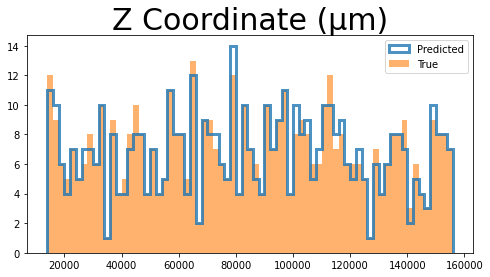

In [11]:
# predicted mask histogram (use step), axis labels, etc

plt.figure(figsize=(8,4))
plt.hist(z_pred, bins=np.arange(14000,158000,2000), alpha=0.8, label='Predicted', histtype='step', linewidth=3)
plt.hist(z_true, bins=np.arange(14000,158000,2000), alpha=0.6, label='True')
# plt.hist(z_part, bins=np.arange(14000,158000,2000), alpha=0.6, label='true')
# plt.xlabel('z-coordinate (µm)')
plt.title("Z Coordinate (µm)", fontsize=30)
# plt.xticks([])
# plt.yticks([])
plt.legend()
plt.savefig(f"{model_save}inference/hist_z_{h_idx}.png")
plt.show()


In [12]:
print(max(d_part))
print(max(d_true))
print(max(d_pred))

print(min(d_part))
print(min(d_true))
print(min(d_pred))

95.076485
85.84
85.84
2.1926262
2.96
2.96


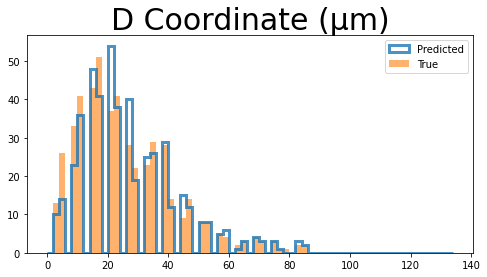

In [13]:
# predicted mask histogram (use step), axis labels, etc

plt.figure(figsize=(8,4))
plt.hist(d_pred, bins=np.arange(0,136,2), alpha=0.8, label='Predicted', histtype='step', linewidth=3)
plt.hist(d_true, bins=np.arange(0,136,2), alpha=0.6, label='True')
# plt.hist(d_part, bins=np.arange(0,136,2), alpha=0.6, label='true')
# plt.xlabel('diameter (µm)')
plt.title("D Coordinate (µm)", fontsize=30)
# plt.xticks([])
# plt.yticks([])
plt.legend()
plt.savefig(f"{model_save}inference/hist_d_{h_idx}.png")
plt.show()


In [14]:
print(max(y_part))
print(max(y_true))
print(max(y_pred))

print(min(y_part))
print(min(y_true))
print(min(y_pred))

4783.2334
4802.6
4817.4
-4798.2583
-4778.92
-4781.88


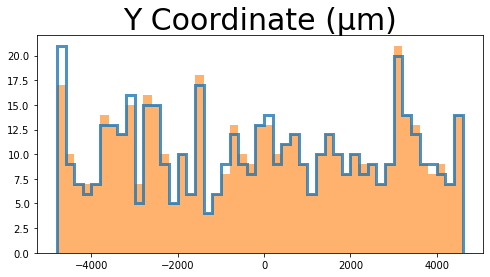

In [15]:
# predicted mask histogram (use step), axis labels, etc

plt.figure(figsize=(8,4))
plt.hist(y_pred, bins=np.arange(-4800,4800,200), alpha=0.8, label='Predicted', histtype='step', linewidth=3)
plt.hist(y_true, bins=np.arange(-4800,4800,200), alpha=0.6, label='True')
# plt.hist(y_part, bins=np.arange(-4800,4800,200), alpha=0.6, label='true')
# plt.xlabel('y-coordinate (µm)')
plt.title("Y Coordinate (µm)", fontsize=30)
# plt.xticks([])
# plt.yticks([])
# plt.legend()
plt.savefig(f"{model_save}inference/hist_y_{h_idx}.png")
plt.show()


In [16]:
print(max(x_part))
print(max(x_true))
print(max(x_pred))

print(min(x_part))
print(min(x_true))
print(min(x_pred))

7110.638
7220.92
7220.92
-7209.32
-7155.8
-7069.960000000001


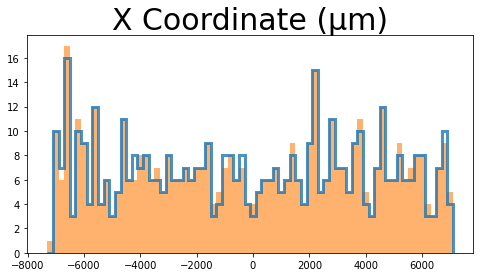

In [17]:
# predicted mask histogram (use step), axis labels, etc

plt.figure(figsize=(8,4))
plt.hist(x_pred, bins=np.arange(-7300,7300,200), alpha=0.8, label='Predicted', histtype='step', linewidth=3)
plt.hist(x_true, bins=np.arange(-7300,7300,200), alpha=0.6, label='True')
# plt.hist(x_part, bins=np.arange(-7300,7300,200), alpha=0.6, label='true')
# plt.xlabel('x-coordinate (µm)')
plt.title("X Coordinate (µm)", fontsize=30)
# plt.xticks([])
# plt.yticks([])
# plt.legend()
plt.savefig(f"{model_save}inference/hist_x_{h_idx}.png")
plt.show()


### 3D Visualizations

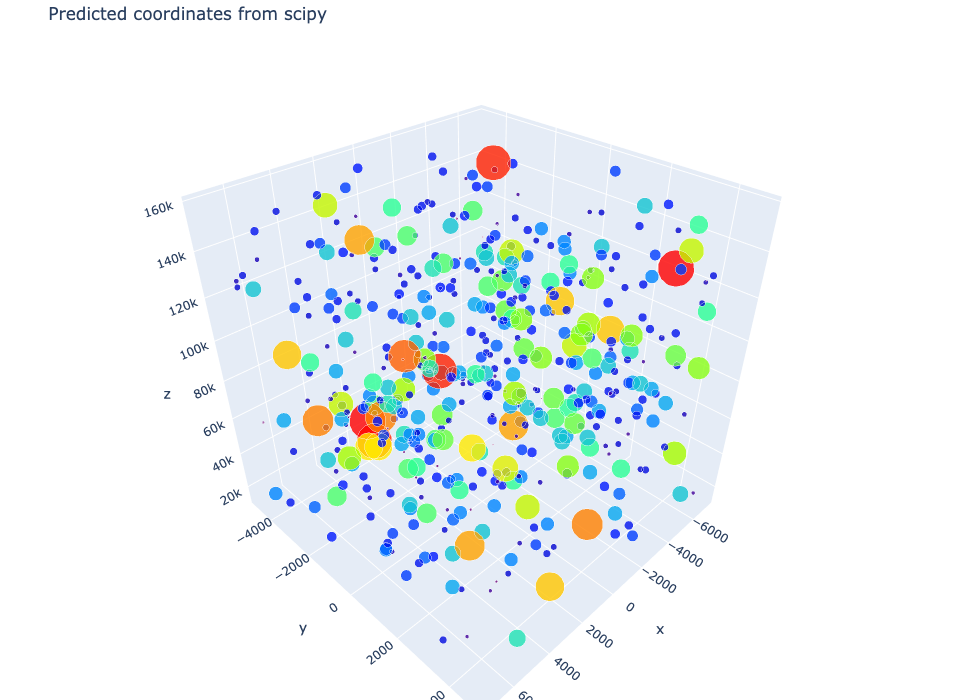

In [18]:
data = [go.Scatter3d(x=x_pred,
                     y=y_pred,
                     z=z_pred,
                     mode='markers',
                     marker=dict(size=d_pred/2,
                                 color=d_pred,
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_pred_i}" for d_pred_i in d_pred])]

layout = go.Layout(title='Predicted coordinates from scipy',
                   autosize=True,
                   width=700,
                   height=700,
                   xaxis= go.layout.XAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   yaxis= go.layout.YAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   margin=go.layout.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=40
                   )
                   )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1))
fig.update_layout(hovermode="x")
fig.show()


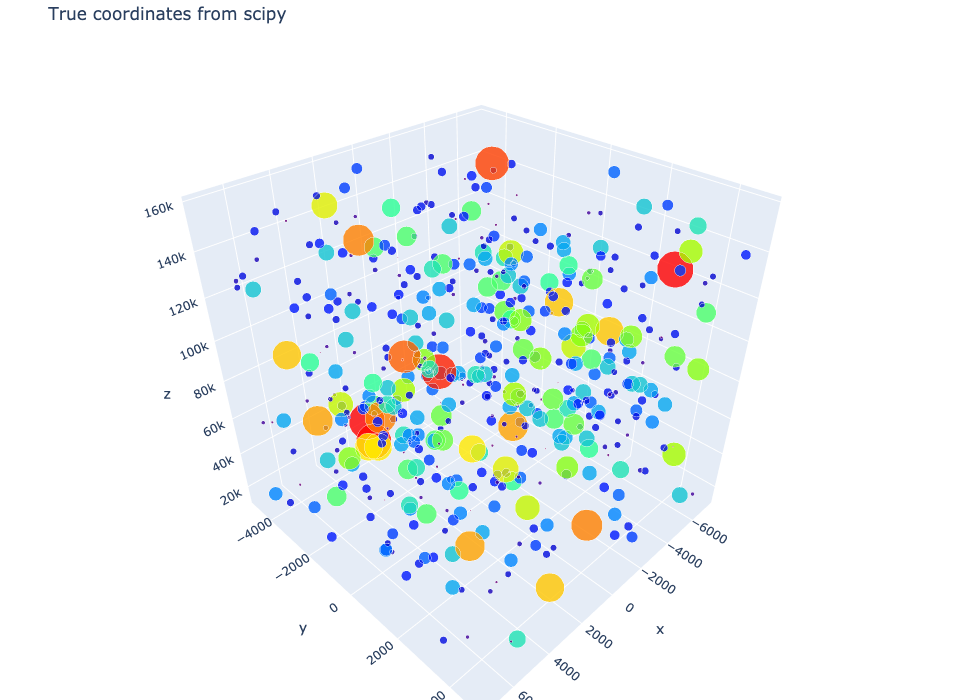

In [19]:
data = [go.Scatter3d(x=x_true,
                     y=y_true,
                     z=z_true,
                     mode='markers',
                     marker=dict(size=d_true/2,
                                 color=d_true,
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_true_i}" for d_true_i in d_true])]

layout = go.Layout(title='True coordinates from scipy',
                   autosize=True,
                   width=700,
                   height=700,
                   xaxis= go.layout.XAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   yaxis= go.layout.YAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   margin=go.layout.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=40
                   )
                   )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1))
fig.update_layout(hovermode="x")
fig.show()


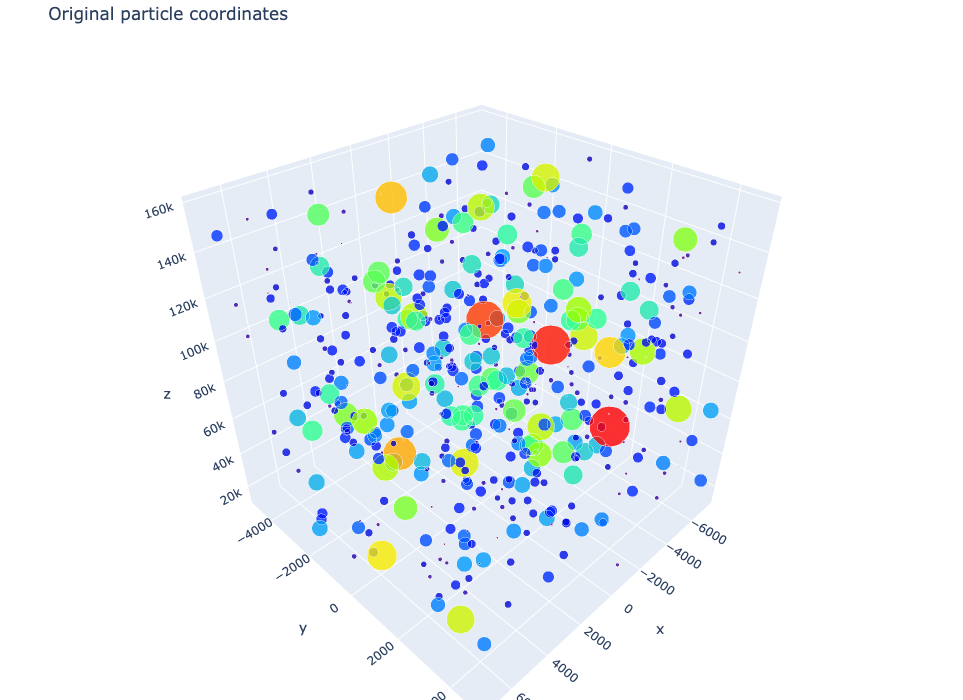

In [20]:
data = [go.Scatter3d(x=x_part,
                     y=y_part,
                     z=z_part,
                     mode='markers',
                     marker=dict(size=d_part/2,
                                 color=d_part,
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_part_i}" for d_part_i in d_part])]

layout = go.Layout(title='Original particle coordinates',
                   autosize=True,
                   width=700,
                   height=700,
                   xaxis= go.layout.XAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   yaxis= go.layout.YAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   margin=go.layout.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=40
                   )
                   )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1))
fig.update_layout(hovermode="x")
fig.show()


In [ ]:
def calc_z_relative_mass(outputs, num_z_bins=20, z_bins=None):
    """
    Calculate z-relative mass from particle data.
    
    Args: 
        outputs: (df) Output data specified by output_col 
        num_z_bins: (int) Number of bins for z-axis linspace
        z_bins: (np array) Bin linspace along the z-axis
    
    Returns:
        z_mass: (np array) Particle mass distribution by hologram along z-axis
        z_bins: (np array) Bin linspace along the z-axis
    """
    
    if z_bins is None:
        z_bins = np.linspace(outputs["z"].min() - 100,
                             outputs["z"].max() + 100,
                             num_z_bins)
    else:
        num_z_bins = z_bins.size
    holograms = len(outputs["hid"].unique())
    z_mass = np.zeros((holograms, num_z_bins), dtype=np.float32)
    for i in range(outputs.shape[0]):
        z_pos = np.searchsorted(z_bins, outputs.loc[i, "z"], side="right") - 1
        mass = 4 / 3 * np.pi * (outputs.loc[i, "d"]/2)**3
        z_mass[int(outputs.loc[i, "hid"]) - 1, z_pos] += mass
    z_mass /= np.expand_dims(z_mass.sum(axis=1), -1)
    return z_mass, z_bins


## Calculating Particle Distance and MAE

<!-- ### Calculating the Euclidian Distance -->

In [21]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [22]:
mae_x = np.abs(normalize(x_pred).reshape(-1,1) - normalize(x_part).reshape(1,-1))
mae_y = np.abs(normalize(y_pred).reshape(-1,1) - normalize(y_part).reshape(1,-1))
mae_z = np.abs(normalize(z_pred).reshape(-1,1) - normalize(z_part).reshape(1,-1))
mae_d = np.abs(normalize(d_pred).reshape(-1,1) - normalize(d_part).reshape(1,-1))
mae_total = mae_x + mae_y + mae_z + mae_d


In [23]:
d_x = (normalize(x_pred).reshape(-1,1) - normalize(x_part).reshape(1,-1)) ** 2
print(d_x.mean())
# d_x = np.where(d_x > d_x.mean(), 1, d_x)

d_y = (normalize(y_pred).reshape(-1,1) - normalize(y_part).reshape(1,-1)) ** 2
print(d_y.mean())
# d_y = np.where(d_y > d_y.mean(), 1, d_y)

d_z = (normalize(z_pred).reshape(-1,1) - normalize(z_part).reshape(1,-1)) ** 2
print(d_z.mean())
# d_z = np.where(d_z > d_z.mean(), 1, d_z)

d_d = (normalize(d_pred).reshape(-1,1) - normalize(d_part).reshape(1,-1)) ** 2
print(d_d.mean())
# d_d = np.where(d_d > d_d.mean(), 1, d_d)

distance_wd = d_x + d_y + d_z + d_d
distance = d_x + d_y + d_z
print(f"Count of unique true particles that have been matched including diameter in calculation: {np.unique(np.argmin(distance_wd, axis=1)).shape[0]}")
print(f"Count of unique true particles that have been matched: {np.unique(np.argmin(distance, axis=1)).shape[0]}")


0.17671451463214663
0.17105285652157923
0.16631180152726666
0.06869411921410729
Count of unique true particles that have been matched including diameter in calculation: 289
Count of unique true particles that have been matched: 293


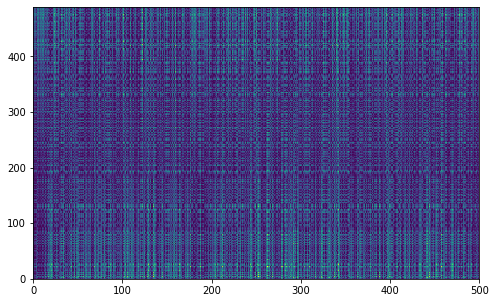

In [145]:
plt.figure(figsize=(8,5))
plt.pcolormesh(distance)
plt.show()


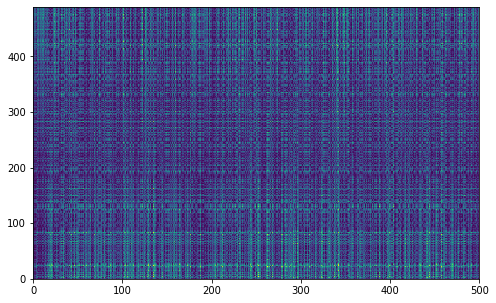

In [146]:
plt.figure(figsize=(8,5))
plt.pcolormesh(distance_wd)
plt.show()


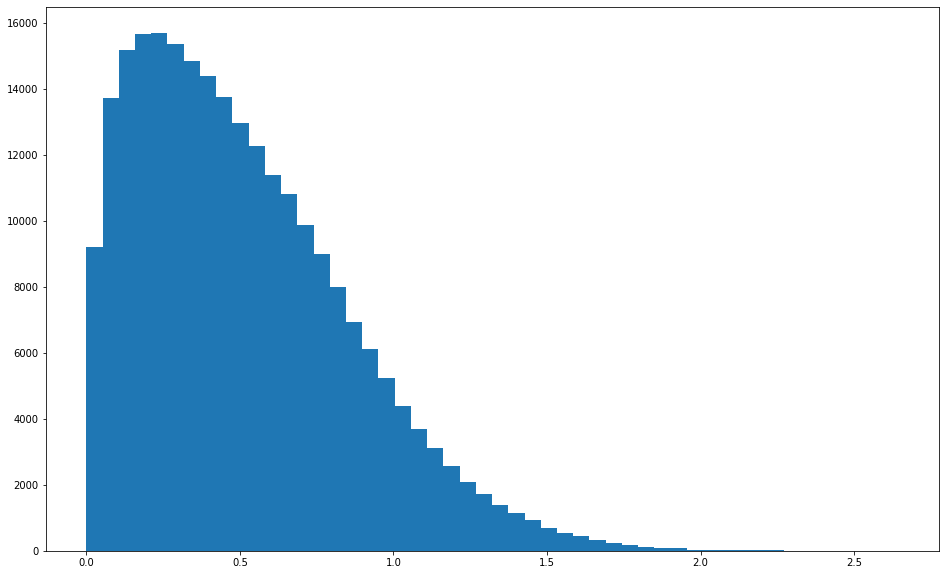

In [26]:
plt.figure(figsize=(16,10))
plt.hist(distance.flatten(), bins=50)
plt.show()


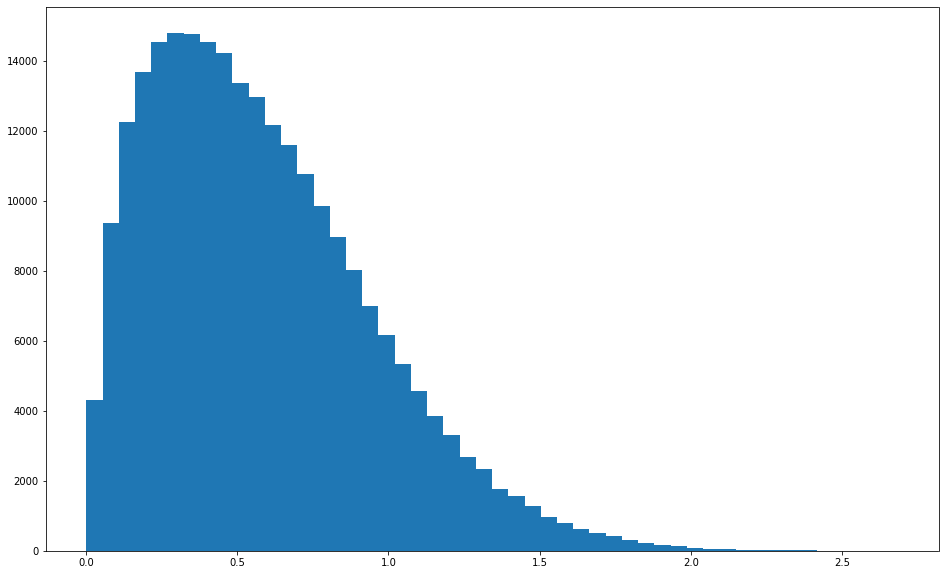

In [27]:
plt.figure(figsize=(16,10))
plt.hist(distance_wd.flatten(), bins=50)
plt.show()


In [28]:
min_idx = np.argmin(distance, axis=1)
distances = []
dist = 0
maes = []
mae = 0

for i in range(distance.shape[0]):
    dist += distance[i, min_idx[i]]
#     print(distance[i, min_idx[i]])
    distances.append(distance[i, min_idx[i]])
    mae += mae_total[i, min_idx[i]]
#     print(mae_total[i, min_idx[i]])
    maes.append(mae_total[i, min_idx[i]])
    
print(f"Total distance of predicted vs true particles once they have been matched: {dist:,.2f}")
print(f"MAE of predicted vs true particles once they have been matched: {mae:,.2f}")


Total distance of predicted vs true particles once they have been matched: 3.15
MAE of predicted vs true particles once they have been matched: 152.60


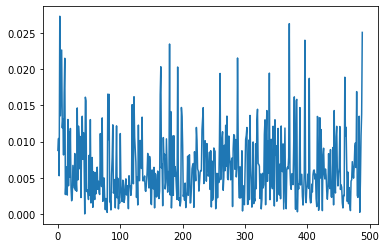

In [29]:
plt.plot(distances)

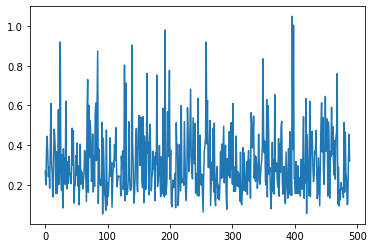

In [31]:
plt.plot(maes)

### Using MunkRes (without diameters)

In [ ]:
start_munkres = datetime.now()
m = Munkres()
indexes = m.compute(distance)
print(f"Munkres took {datetime.now() - start_munkres} time")


In [ ]:
total = 0
distances_withoutd = []
for row, column in indexes:
    value = distance[row][column]
    distances_withoutd.append(distance[row][column])
    total += value
#     print(f'({row}, {column}) -> {value}')
print(f'total profit={total}')


In [ ]:
min(distances_withoutd)


In [ ]:
distances_withoutd.index(0.00017803516907691986)


In [ ]:
unique_true_particle_idx = list(set([i[1] for i in indexes]))
len(unique_true_particle_idx)


In [ ]:
pred_idx = 459
data = [go.Scatter3d(x=np.array((x_pred[pred_idx], x_part[indexes[pred_idx][1]])),
                     y=np.array((y_pred[pred_idx], y_part[indexes[pred_idx][1]])),
                     z=np.array((z_pred[pred_idx], z_part[indexes[pred_idx][1]])),
                     mode='markers',
                     marker=dict(size=np.array((d_pred[pred_idx], d_part[indexes[pred_idx][1]]))/2,
                                 color=np.array((0,1)),
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_i:.2f} ({t})" for d_i,t in zip([d_pred[pred_idx], d_part[indexes[pred_idx][1]]], ['Pred', 'True'])])]

layout = go.Layout(title='Comparison of predicted to paired true particles',
                   width=700,
                   height=700,
                   xaxis= go.layout.XAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   yaxis= go.layout.YAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   margin=go.layout.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=40
                   )
                   )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1),
                  scene = dict(xaxis = dict(nticks=6, range=[-7300, 7300]),
                               yaxis = dict(nticks=6, range=[-4800, 4800]),
                               zaxis = dict(nticks=6, range=[14000, 158000])))
fig.update_layout(hovermode="x")
fig.show()


### Using MunkRes (with diameters)

In [ ]:
start_munkres = datetime.now()
m = Munkres()
indexes_wd = m.compute(distance_wd)
print(f"Munkres took {datetime.now() - start_munkres} time")


In [ ]:
total_wd = 0
for row, column in indexes_wd:
    value = distance_wd[row][column]
    total_wd += value
#     print(f'({row}, {column}) -> {value}')
print(f'total profit={total_wd}')


In [ ]:
unique_true_particle_idx_wd = list(set([i[1] for i in indexes_wd]))
len(unique_true_particle_idx_wd)


In [ ]:
pred_idx = 1
data = [go.Scatter3d(x=np.array((x_pred[pred_idx], x_part[indexes_wd[pred_idx][1]])),
                     y=np.array((y_pred[pred_idx], y_part[indexes_wd[pred_idx][1]])),
                     z=np.array((z_pred[pred_idx], z_part[indexes_wd[pred_idx][1]])),
                     mode='markers',
                     marker=dict(size=np.array((d_pred[pred_idx], d_part[indexes_wd[pred_idx][1]]))/2,
                                 color=np.array((0,1)),
                                 colorscale='Rainbow',
                                 opacity=0.8),
                     text = [f"diameter: {d_i:.2f} ({t})" for d_i,t in zip([d_pred[pred_idx], d_part[indexes_wd[pred_idx][1]]], ['Pred', 'True'])])]

layout = go.Layout(title='Comparison of predicted to paired true particles',
                   width=700,
                   height=700,
                   xaxis= go.layout.XAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   yaxis= go.layout.YAxis(linecolor = 'black',
                                          linewidth = 1,
                                          mirror = True),
                   margin=go.layout.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=40
                   )
                   )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1),
                  scene = dict(xaxis = dict(nticks=6, range=[-7300, 7300]),
                               yaxis = dict(nticks=6, range=[-4800, 4800]),
                               zaxis = dict(nticks=6, range=[14000, 158000])))
fig.update_layout(hovermode="x")
fig.show()


### Histograms Depicting Average of 10 particles

In [107]:
real = 'synthetic'
particles= {}
dxs = []
dys = []

for h_idx in range(10):
    particles[h_idx] = {}
    
    for true in ('true', 'pred'):
        
        particles[h_idx][true] = {}

        objects = np.load(f"{model_save}inference/{real}/objects_{true}_{h_idx}.npy", allow_pickle=True)
        x = []
        y = []
        z = []
        d = []
        for obj in objects:
            x.append(int(np.mean(obj[1].indices(10000)[:2])))
            y.append(int(np.mean(obj[2].indices(10000)[:2])))
            z.append(z_file_indices[int(np.mean(obj[0].indices(10000)[:2]))])

            d_x = (obj[1].indices(10000)[1] - obj[1].indices(10000)[0]) * dx
            dxs.append(obj[1].indices(10000)[1] - obj[1].indices(10000)[0])
            d_y = (obj[2].indices(10000)[1] - obj[2].indices(10000)[0]) * dy
            dys.append(obj[2].indices(10000)[1] - obj[2].indices(10000)[0])
            d.append(max(d_x, d_y) / 1e-6)

        particles[h_idx][true]['z'] = np.array(z)
        x = np.array(x) * dx * 1e6
        particles[h_idx][true]['x'] = x - (max(x) - min(x)) / 2
        y = np.array(y) * dy * 1e6
        particles[h_idx][true]['y'] = y - (max(y) - min(y)) / 2
        particles[h_idx][true]['d'] = np.array(d)


(array([259., 384., 566., 709., 775., 773., 810., 679., 584., 605., 531.,
        454., 391., 346., 308., 260., 227., 196., 130., 142., 127.,  79.,
        102.,  70.,  50.,  56.,  39.,  40.,  27.,  19.,  12.,  14.,   7.,
          5.,   9.,   8.,   1.,   5.,   4.,   0.,   2.,   0.,   0.,   0.,
          0.,   2.,   0.,   2.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 48 artists>)

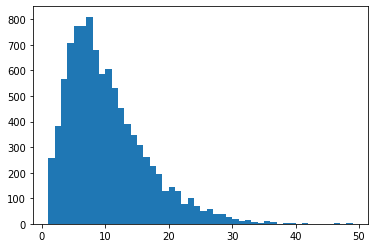

In [108]:
plt.hist(dxs, bins=range(1,50))

In [130]:
bins = {'z': np.arange(14000,158000,2000),
        'x': np.arange(-7300,7300,200),
        'y': np.arange(-4800,4800,200),
        'd': np.arange(0,139,3)}

In [132]:
hist_true_avg = {}
for coord in ['x', 'y', 'z', 'd']:
    hist = []
    for h_idx in range(10):
        h, binEdges = np.histogram(particles[h_idx]['true'][coord], bins=bins[coord])
        hist.append(h)
    hist_true_avg[coord] = np.stack(hist)
    hist_true_avg[coord+'_mean'] = np.stack(hist).mean(axis=0)
    hist_true_avg[coord+'_std'] = np.stack(hist).std(axis=0) / 3
    

In [133]:
hist_pred_avg = {}
for coord in ['x', 'y', 'z', 'd']:
    hist = []
    for h_idx in range(10):
        h, binEdges = np.histogram(particles[h_idx]['pred'][coord], bins=bins[coord])
        hist.append(h)
    hist_pred_avg[coord] = np.stack(hist)
    hist_pred_avg[coord+'_mean'] = np.stack(hist).mean(axis=0)
    hist_pred_avg[coord+'_std'] = np.stack(hist).std(axis=0) / 3
    

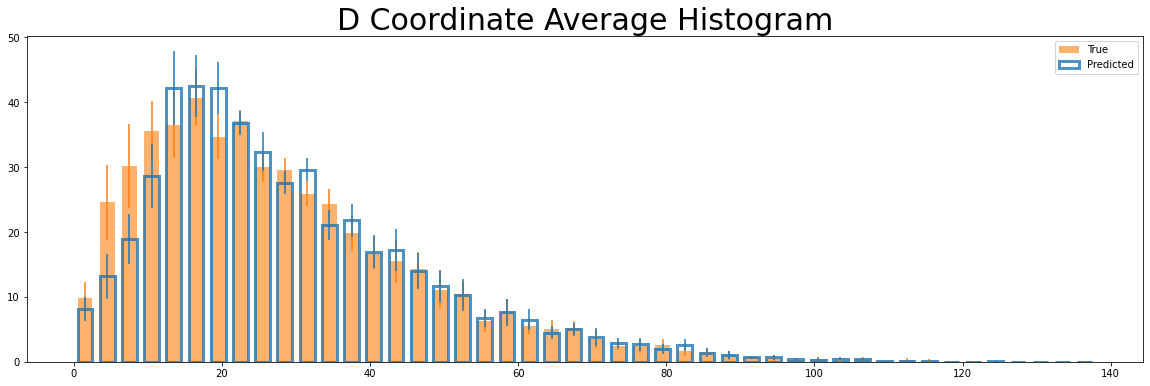

In [137]:
plt.figure(figsize=(20,6))
_, binEdges = np.histogram(particles[h_idx]['pred']['d'], bins=bins['d'])
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.title("D Coordinate Average Histogram", fontsize=30)
plt.bar(bincenters, hist_true_avg['d_mean'], alpha=0.6, width=2, yerr=hist_true_avg['d_std'], color='#ff7f0e', ecolor='#ff7f0e', label='True')
plt.bar(bincenters, hist_pred_avg['d_mean'], alpha=0.8, width=2, fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4', yerr=hist_pred_avg['d_std'], label='Predicted')
plt.legend()
plt.savefig(f"{model_save}inference/hist_d_avg.png")
plt.show()


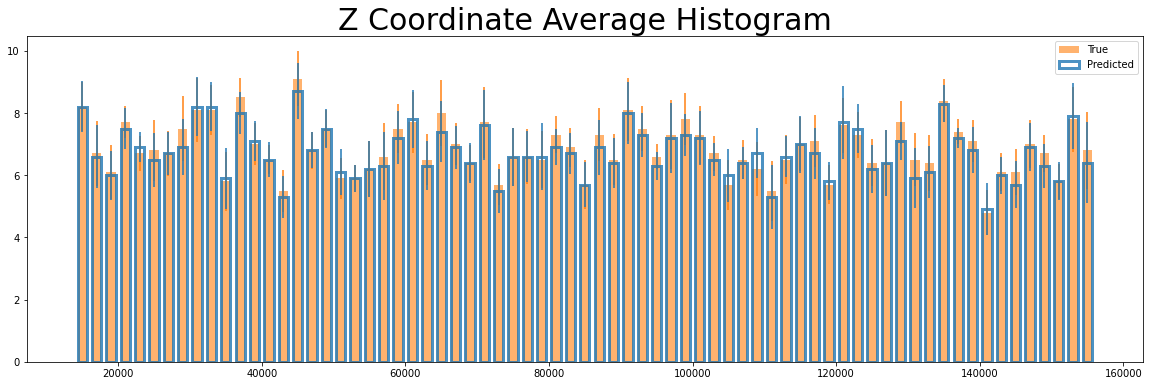

In [141]:
plt.figure(figsize=(20,6))
_, binEdges = np.histogram(particles[h_idx]['pred']['z'], bins=bins['z'])
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.title("Z Coordinate Average Histogram", fontsize=30)
plt.bar(bincenters, hist_true_avg['z_mean'], alpha=0.6, width=1300, yerr=hist_true_avg['z_std'], color='#ff7f0e', ecolor='#ff7f0e', label='True')
plt.bar(bincenters, hist_pred_avg['z_mean'], alpha=0.8, width=1300, yerr=hist_pred_avg['z_std'], fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4', label='Predicted')
plt.legend()
plt.savefig(f"{model_save}inference/hist_z_avg.png")
plt.show()


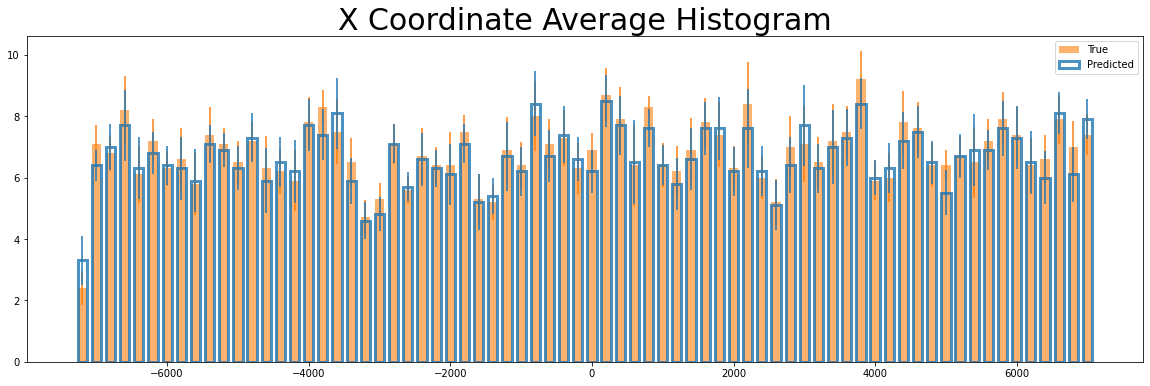

In [142]:
plt.figure(figsize=(20,6))
_, binEdges = np.histogram(particles[h_idx]['pred']['x'], bins=bins['x'])
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.title("X Coordinate Average Histogram", fontsize=30)
plt.bar(bincenters, hist_true_avg['x_mean'], alpha=0.6, width=130, yerr=hist_true_avg['x_std'], color='#ff7f0e', ecolor='#ff7f0e', label='True')
plt.bar(bincenters, hist_pred_avg['x_mean'], alpha=0.8, width=130, fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4', yerr=hist_pred_avg['x_std'], label='Predicted')
plt.legend()
plt.savefig(f"{model_save}inference/hist_x_avg.png")
plt.show()


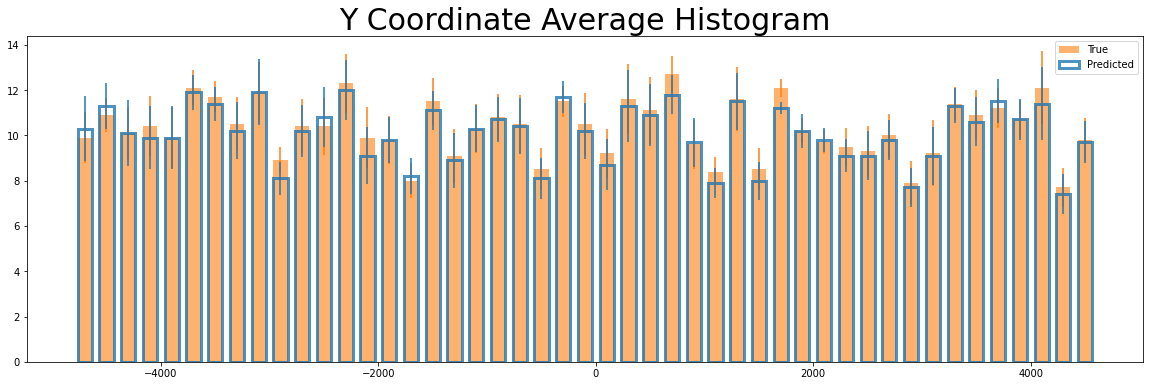

In [143]:
plt.figure(figsize=(20,6))
_, binEdges = np.histogram(particles[h_idx]['pred']['y'], bins=bins['y'])
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.title("Y Coordinate Average Histogram", fontsize=30)
plt.bar(bincenters, hist_true_avg['y_mean'], alpha=0.6, width=130, yerr=hist_true_avg['y_std'], color='#ff7f0e', ecolor='#ff7f0e', label='True')
plt.bar(bincenters, hist_pred_avg['y_mean'], alpha=0.8, width=130, fill=False, linewidth=3, edgecolor='#1f77b4', ecolor='#1f77b4', yerr=hist_pred_avg['y_std'], label='Predicted')
plt.legend()
plt.savefig(f"{model_save}inference/hist_y_avg.png")
plt.show()
